In [3]:
%autosave 120
%matplotlib inline

from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as pl
import qutip as qt
import qinfer as qi

from qinfer.smc import SMCUpdater
from qinfer.resamplers import LiuWestResampler
from qinfer.tomography import Model, RandomPauliHeuristic

from scipy.stats import binom
import scipy.linalg as la
from scipy.optimize import minimize

Autosaving every 120 seconds


In [4]:
KET_1 = qt.basis(2, n=0)
KET_0 = qt.basis(2, n=1)
I, X, Y, Z = qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()
PSI = qt.tensor(KET_0, KET_1) + 1.j * qt.tensor(KET_1, KET_0)
PSI /= PSI.norm()
RHO = .95 * PSI * PSI.dag() + .05 * qt.identity([2, 2])

In [5]:
class IncompleteBasis(object):
    def __init__(self, data):
        """data should not include the identity"""
        self._data = np.array(data)
        self._dim = self._data.shape[-1]
        
    def __len__(self):
        return len(self._data)
    
    @property
    def data(self):
        return self._data
        
    @property
    def dim(self):
        return self._dim
 
    def flat(self):
        return self._data.reshape((self._data.shape[0], -1))
        
    def modelparams_to_state(self, params):
        assert len(params) == len(self._data)
        return sum(params[:, None, None] * self._data, np.eye(self.dim) / self.dim)

    def state_to_modelparams(self, rho):
        assert tuple(rho.shape) == (self.dim,) * 2
        # Should be real, since Basis should be hermitian
        if isinstance(rho, qt.Qobj):
            rho = np.asarray(rho.data.todense()).ravel()
        else:
            rho = rho.ravel()
            
        d = self.dim
        return np.fromiter((np.real(np.dot(b.ravel(), rho)) for b in self._data),
                            dtype=np.float64)    
    
XYZ = [X, Y, Z]
BASIS_ELEMENTS = [qt.tensor(m1, m2) for m1 in XYZ for m2 in XYZ]
BASIS = IncompleteBasis([mat.data.todense() / np.sqrt(4) for mat in BASIS_ELEMENTS])

In [6]:
len(BASIS)

9

In [7]:
def hsu(dim):
    """Samples from the Hilbert Schmidt measure on the pos. semidefinite
    dim*dim matrices with trace one
    """
    #Generate random unitary (see e.g. http://arxiv.org/abs/math-ph/0609050v2)
    g = (np.random.randn(dim, dim) + 1j*np.random.randn(dim,dim))/np.sqrt(2.0)
    q,r = la.qr(g)
    d = np.diag(r)

    ph = d / np.abs(d)
    ph = np.diag(ph)

    U = np.dot(q,ph)

    #Generate random matrix
    z = np.random.randn(dim, dim) + 1j*np.random.randn(dim,dim)

    rho = np.dot(np.dot(np.identity(dim)+U,np.dot(z,z.conj().transpose())),np.identity(dim)+U.conj().transpose())
    rho = rho/np.trace(rho)

    return rho

In [8]:
class HilbertSchmidt(qi.SingleSampleMixin, qi.Distribution):
    def __init__(self, basis):
        self._basis = basis   # DONT INCLUDE eye !!!
        
    def _sample(self):
        rho = hsu(self._basis.dim)
        # basis should be hermitian anyway
        return self._basis.state_to_modelparams(rho)
    
    @property
    def n_rvs(self):
        return len(self._basis)
    
PRIOR = HilbertSchmidt(BASIS)

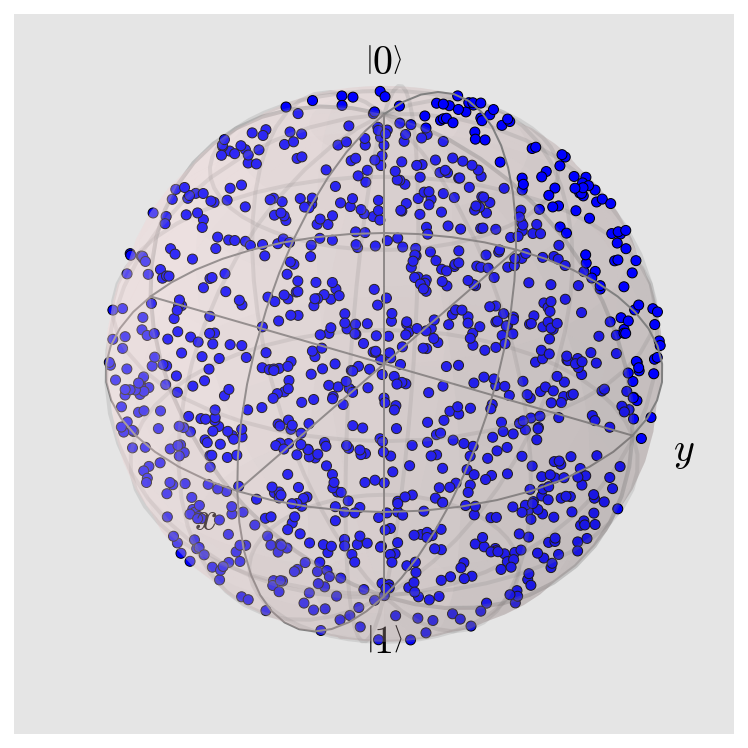

In [9]:
ball = qt.Bloch()
basis_one_qubit = IncompleteBasis([mat.data.todense() / np.sqrt(2) for mat in [X, Y, Z]])
sample = np.sqrt(2) * HilbertSchmidt(basis_one_qubit).sample(1000).T
ball.add_points(sample)
ball.show()

In [10]:
class IncompleteBasisModel(Model):
    def __init__(self, basis):
        self._basis = basis
        super(IncompleteBasisModel, self).__init__()
        
    @property
    def basis(self):
        return self._basis

    @property
    def dim(self):
        return self._basis.dim

    @property
    def n_modelparams(self):
        return len(self._basis)

    @property
    def is_n_outcomes_constant(self):
        return True

    @property
    def expparams_dtype(self):
        return [
            ('meas', float, self.n_modelparams)
        ]

    def n_outcomes(self, expparams):
        return 2

    def are_models_valid(self, modelparams):
        # This is wrong, but is wrong for the sake of speed.
        # As a future improvement, validity checking needs to
        # be enabled as a non-default option.
        return np.ones((modelparams.shape[0],), dtype=bool)

    def canonicalize(self, modelparams):
        modelparams = np.apply_along_axis(self.trunc_neg_eigs, 1, modelparams)
        return modelparams

    def trunc_neg_eigs(self, particle):
        dim = self._basis.dim
        arr = np.eye(dim) / dim + np.tensordot(particle, self._basis.data.conj(), 1)
        # There is a difference between the above and:
        #arr = self._basis.modelparams_to_state(particle)
        w, v = np.linalg.eig(arr)
        if np.all(w >= 0):
            return particle
        else:
            w[w < 0] = 0
            new_arr = np.dot(v * w, v.conj().T)
            new_particle = np.real(np.dot(self._basis.flat(), new_arr.flatten()))
            return new_particle

    def likelihood(self, outcomes, modelparams, expparams):
        super(IncompleteBasisModel, self).likelihood(outcomes, modelparams, expparams)

        pr1 = np.empty((modelparams.shape[0], expparams.shape[0]))

        pr1[:, :] = np.einsum('ei,mi->me', expparams['meas'], modelparams)
        # account for the Identity matrix lacking in parametrization
        pr1 += 1 / self._basis.dim
        np.clip(pr1, 0, 1, out=pr1)
        return Model.pr0_to_likelihood_array(outcomes, 1 - pr1)
    
    def state_to_modelparams(self, rho):
        return self._basis.state2para(rho)

BASIC_MODEL = IncompleteBasisModel(BASIS)
MODEL = qi.BinomialModel(BASIC_MODEL)

In [12]:
from random import shuffle

updater = SMCUpdater(MODEL, 5000, PRIOR)
designs = [[1 / np.sqrt(2), 0.0, 0.0],
          [0.0, 1 / np.sqrt(2), 0.0],
          [0.0, 0.0, 1 / np.sqrt(2)]]

true_state = BASIS.state_to_modelparams((I - X) / 2)

shuffle(designs)
for raw_design in designs:
    design = np.array([(raw_design, 100)], dtype=MODEL.expparams_dtype)
    observation = MODEL.simulate_experiment(true_state[None, :], design)
    updater.update(observation, design)

ball = qt.Bloch()
sample = np.sqrt(2) * updater.sample(1000).T
ball.add_points(sample)
ball.add_states(qt.Qobj(BASIS.modelparams_to_state(true_state)))
ball.show()

AssertionError: 